<a href="https://colab.research.google.com/github/Alvis12/deep_learning/blob/main/GolD(Timeseries_Forecast)_ANN_Demo_for_class_2023_Student_ver(Colab).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Basic packages always been used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data scaling
from sklearn.preprocessing import MinMaxScaler

# Function for spilting training & testing data set
from sklearn.model_selection import train_test_split

# Tensorflow sequential models
from tensorflow import keras
from keras import backend as clear
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.optimizers import SGD
from keras.optimizers import Adam

# Functions for evaluation
from sklearn.metrics import mean_absolute_error #MAE
from sklearn.metrics import mean_squared_error #MSE,RMSE
from sklearn.metrics import mean_absolute_percentage_error #MAPE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Note: Some metrics need to be defined manually

In [ ]:
# Symmetric Mean Absolute Percentage Error (SMAPE)
def SMAPE_calulate(y_true, y_pred):
    n = len(y_true)
    SMAPE=(100 / n) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))
    return SMAPE

# Relative Absolute Error (RAE)
def RAE_calculate(y_true, y_pred):
    abs_errors = np.abs(y_true - y_pred)
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    RAE=np.sum(abs_errors/denominator)
    return RAE

# Mean Relative Absolute Error (MRAE)
def MRAE_calculate(y_true, y_pred):
    n=len(y_true)
    abs_errors = np.abs(y_true - y_pred)
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    RAE=np.sum(abs_errors/denominator)
    MRAE=RAE/n
    return MRAE

# Median Relative Absolute Error (MdRAE) comparing with benchmark
# Note: By default, the bench value is the mean of actual value
def MdRAE_calculate(y_true, y_pred, bench=None):
    if bench==None:
        bench=np.mean(y_true)
        MdRAE=np.median(np.abs(y_true - y_pred)/np.abs(y_true - bench))
        return MdRAE,bench
    else:
        MdRAE=np.median(np.abs(y_true - y_pred)/np.abs(y_true - bench))
        return MdRAE
    
# Relative Squared Error (RSE) & Root Relative Squared Error (RRSE)
def RSE_calculate(y_true, y_pred, Root=False):
    mse = np.mean((y_true - y_pred)**2)
    denominator = np.var(y_true)
    RSE=mse/denominator
    
    if Root==True:
        return np.sqrt(RSE)
    else:
        return RSE

In [ ]:
#load data(sometimes need to use "/")
#df = pd.read_csv('D:/pythonData/python_demo_data/Rainfall_Forecast.csv')
# Colab
df = pd.read_csv('/content/drive/MyDrive/ann_timeseries/GOLD (1).csv')
df

,Date,Y
0,2020/5/27,23.920000
1,2020/5/28,23.950001
2,2020/5/29,24.000000
3,2020/6/1,24.780001
4,2020/6/2,23.950001
...,...,...
752,2023/5/22,17.790001
753,2023/5/23,17.750000
754,2023/5/24,17.480000
755,2023/5/25,17.090000


# 1. Preparations for time-series data

Note: Pandas has a specific data type for time-series data

In [ ]:
# 1.1 Convert date
df['Date']=pd.to_datetime(df['Date'])
df

,Date,Y
0,2020-05-27,23.920000
1,2020-05-28,23.950001
2,2020-05-29,24.000000
3,2020-06-01,24.780001
4,2020-06-02,23.950001
...,...,...
752,2023-05-22,17.790001
753,2023-05-23,17.750000
754,2023-05-24,17.480000
755,2023-05-25,17.090000


In [ ]:
# Date is converted into special data type of pandas
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 757 entries, 0 to 756
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    757 non-null    datetime64[ns]
 1   Y       757 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 12.0 KB


In [ ]:
new_df=df.iloc[:,[0,1]].copy()
new_df.head()

,Date,Y
0,2020-05-27,23.920000
1,2020-05-28,23.950001
2,2020-05-29,24.000000
3,2020-06-01,24.780001
4,2020-06-02,23.950001


In [ ]:
# View descriptive statistics of target variable
# Pandas will automatically ignore date if the correct data type has been converted
df.describe()#統計呈現

,Y
count,757.000000
mean,20.931361
std,3.885816
min,13.100000
25%,18.370001
50%,20.240000
75%,23.580000
max,30.459999


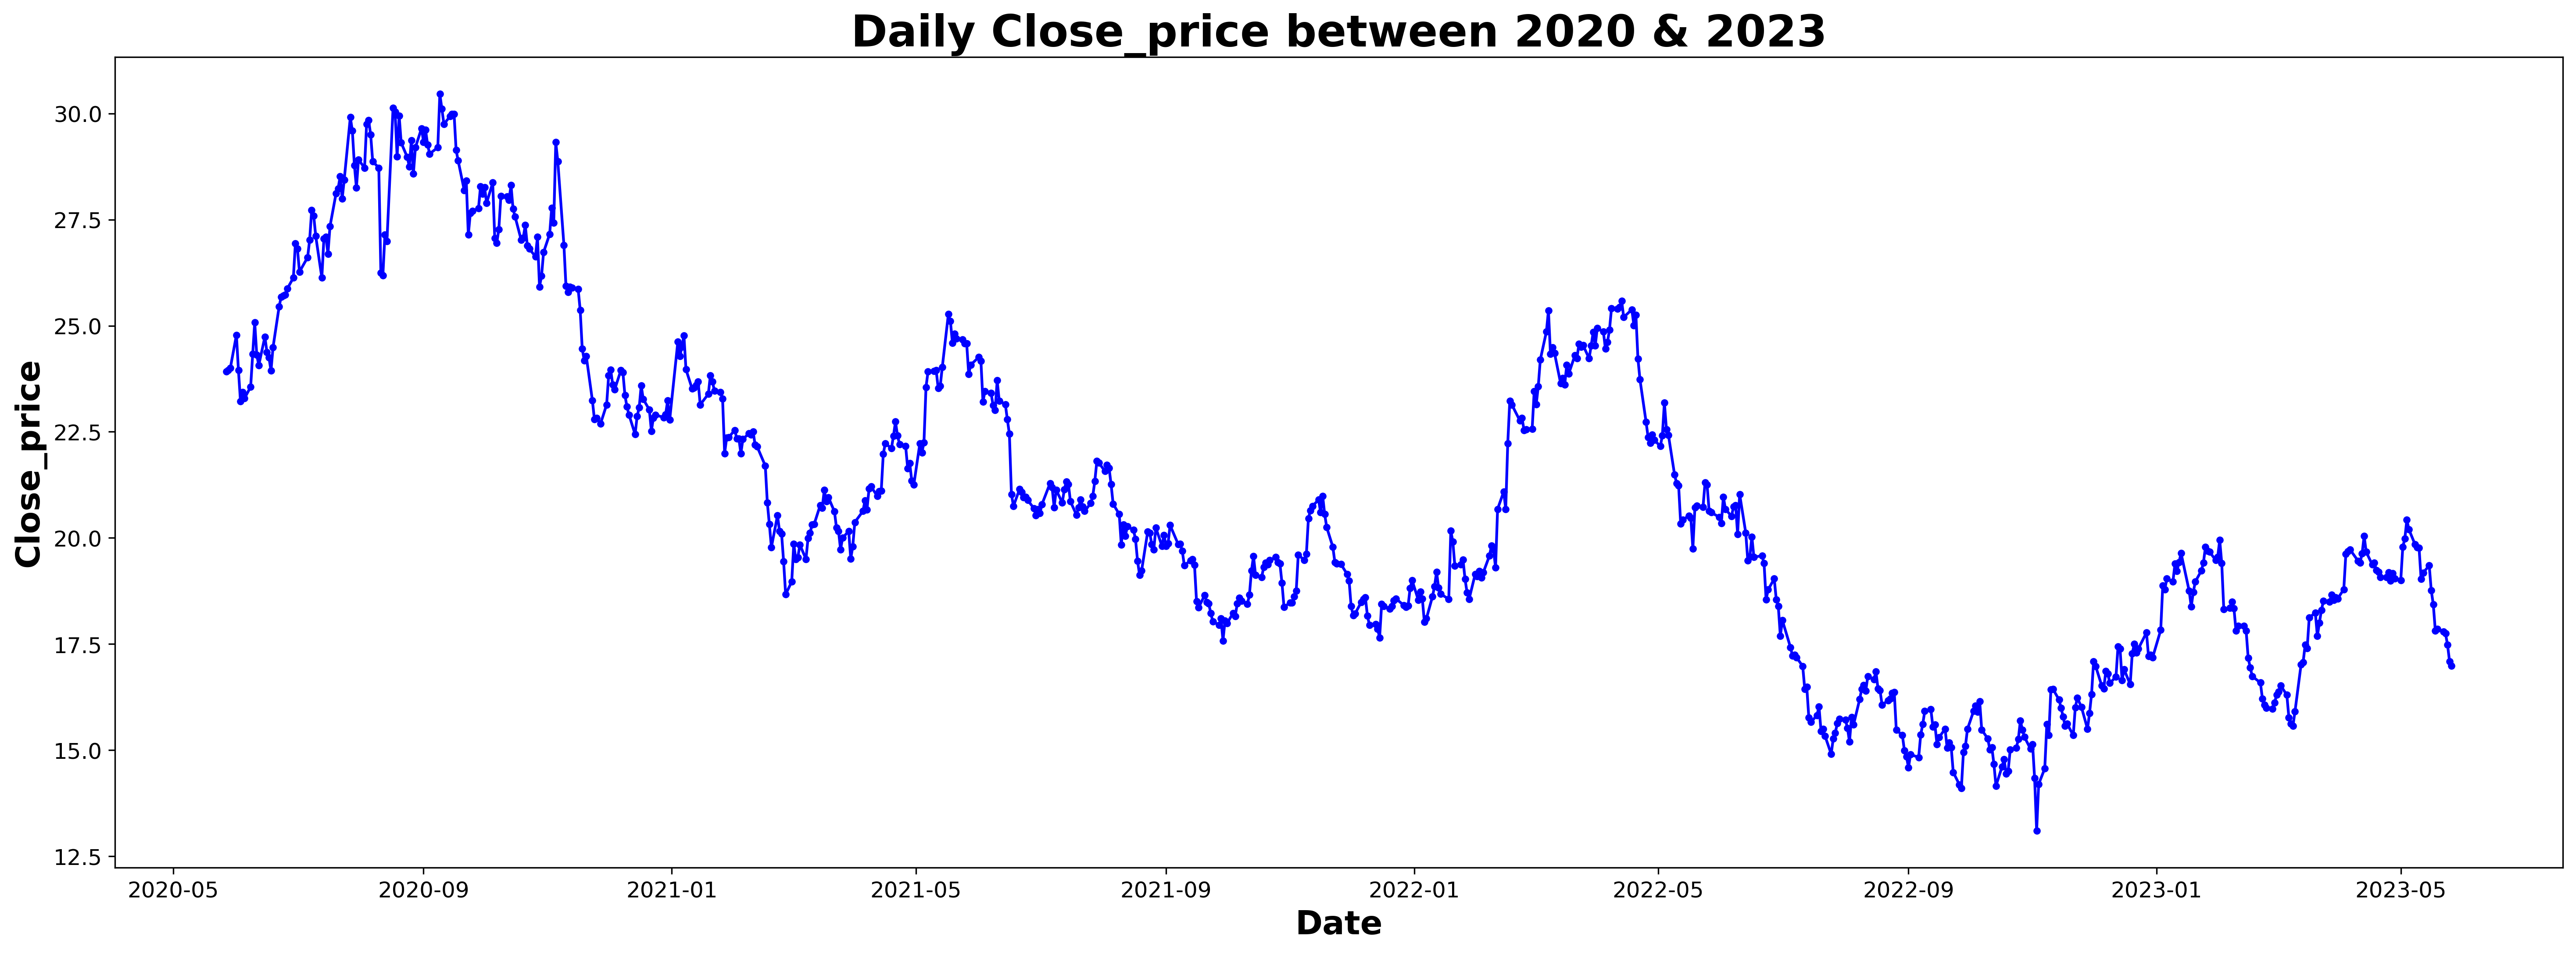

In [ ]:
# Plot Y and its corresponding date
# Figure setting
plt.figure(figsize=(24,8),dpi=300)
plt.title('Daily Close_price between 2020 & 2023',weight='bold',fontsize=24)
plt.xlabel('Date',fontsize=18,weight='bold')
plt.ylabel('Close_price',fontsize=18,weight='bold')

# Actual by predicted plot
plt.plot(new_df['Date'],new_df['Y'],marker='.',color='blue')

# Set the axis
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# 2. Creating time lags as predictor variables

# Important!: Be caution when dealing with time-series data

python do have various packages and function that can deal with time-series data with ease, however, make sure that you understand the fundamental first!

In [ ]:
# Create 3 lags
#做3個time_lag出來 有NaN是因為時間序列裡未發生的事情不能做為資料來分析
new_df['Lag_1']=new_df['Y'].shift(1).copy()
new_df['Lag_2']=new_df['Y'].shift(2).copy()
new_df['Lag_3']=new_df['Y'].shift(3).copy()
new_df.head()

,Date,Y,Lag_1,Lag_2,Lag_3
0,2020-05-27,23.920000,NaN,NaN,NaN
1,2020-05-28,23.950001,23.920000,NaN,NaN
2,2020-05-29,24.000000,23.950001,23.920000,NaN
3,2020-06-01,24.780001,24.000000,23.950001,23.920000
4,2020-06-02,23.950001,24.780001,24.000000,23.950001


In [ ]:
# Drop out missing values and rest index
#解決辦法為把資料整筆刪掉
clean_df=new_df.dropna(axis=0, how='any').copy()
clean_df=clean_df.reset_index(drop=True)
clean_df

,Date,Y,Lag_1,Lag_2,Lag_3
0,2020-06-01,24.780001,24.000000,23.950001,23.920000
1,2020-06-02,23.950001,24.780001,24.000000,23.950001
2,2020-06-03,23.219999,23.950001,24.780001,24.000000
3,2020-06-04,23.430000,23.219999,23.950001,24.780001
4,2020-06-05,23.290001,23.430000,23.219999,23.950001
...,...,...,...,...,...
749,2023-05-22,17.790001,17.860001,17.809999,18.430000
750,2023-05-23,17.750000,17.790001,17.860001,17.809999
751,2023-05-24,17.480000,17.750000,17.790001,17.860001
752,2023-05-25,17.090000,17.480000,17.750000,17.790001


In [ ]:
# Export the data
#clean_df.to_csv('D:/data_analysis/PyExport/Rainfall_Lags.csv',index=False, header=True)
# Colab
#clean_df.to_csv('Rainfall_Lags.csv',index=False, header=True)

# 3. Data preprocessing under time-series structure

A total of 21 years are in the data set. In this practice, we will use the last three years of data as the testing set

In [ ]:
# Train data
Forecast_train_data=clean_df.iloc[0:646,:].copy()
Forecast_train_data

,Date,Y,Lag_1,Lag_2,Lag_3
0,2020-06-01,24.780001,24.000000,23.950001,23.920000
1,2020-06-02,23.950001,24.780001,24.000000,23.950001
2,2020-06-03,23.219999,23.950001,24.780001,24.000000
3,2020-06-04,23.430000,23.219999,23.950001,24.780001
4,2020-06-05,23.290001,23.430000,23.219999,23.950001
...,...,...,...,...,...
641,2022-12-14,17.389999,17.440001,16.730000,16.580000
642,2022-12-15,16.650000,17.389999,17.440001,16.730000
643,2022-12-16,16.900000,16.650000,17.389999,17.440001
644,2022-12-19,16.549999,16.900000,16.650000,17.389999


In [ ]:
# Test data
Forecast_test_data=clean_df.iloc[646:646+108,:].copy()
Forecast_test_data

,Date,Y,Lag_1,Lag_2,Lag_3
646,2022-12-21,17.500000,17.280001,16.549999,16.900000
647,2022-12-22,17.299999,17.500000,17.280001,16.549999
648,2022-12-23,17.389999,17.299999,17.500000,17.280001
649,2022-12-27,17.770000,17.389999,17.299999,17.500000
650,2022-12-28,17.209999,17.770000,17.389999,17.299999
...,...,...,...,...,...
749,2023-05-22,17.790001,17.860001,17.809999,18.430000
750,2023-05-23,17.750000,17.790001,17.860001,17.809999
751,2023-05-24,17.480000,17.750000,17.790001,17.860001
752,2023-05-25,17.090000,17.480000,17.750000,17.790001


# 4. Prepare time-series data for train/validation structure manually

# Expanding window

In [ ]:
"""# Expanding 1
Exp_training_1=Forecast_train_data.iloc[0:105,:].copy()
Exp_val_1=Forecast_train_data.iloc[105:105+36,:].copy()

# Expanding 2
Exp_training_2=Forecast_train_data.iloc[0:141,:].copy()
Exp_val_2=Forecast_train_data.iloc[141:141+36,:].copy()

# Expanding 3
Exp_training_3=Forecast_train_data.iloc[0:177,:].copy()
Exp_val_3=Forecast_train_data.iloc[177:177+36,:].copy()"""

# Rolling window

In [ ]:
# Rolling 1
Rol_training_1=Forecast_train_data.iloc[0:322,:].copy()
Rol_val_1=Forecast_train_data.iloc[322:322+108,:].copy()

# Rolling 2
Rol_training_2=Forecast_train_data.iloc[106:430,:].copy()
Rol_val_2=Forecast_train_data.iloc[430:430+108,:].copy()

# Rolling 3
Rol_training_3=Forecast_train_data.iloc[217:538,:].copy()
Rol_val_3=Forecast_train_data.iloc[538:538+108,:].copy()

# 5. Set dependent variable(Y or target) & independent variable(X) 

In [ ]:
"""#set x (make prediction)
# Train
x_train=Exp_training_3.drop(['Date','Y'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingT=MMscaler.fit_transform(x_train)
scaled_x_train=pd.DataFrame(data=scalingT)
scaled_x_train.columns=['Lag_1','Lag_2','Lag_3']

# Validation
x_val=Exp_val_3.drop(['Date','Y'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingV=MMscaler.fit_transform(x_val)
scaled_x_val=pd.DataFrame(data=scalingV)
scaled_x_val.columns=['Lag_1','Lag_2','Lag_3']

#set y (want to predict)
y_train=Exp_training_3['Y'].copy()
y_val=Exp_val_3['Y'].copy()"""

In [ ]:
#set x (make prediction)
# Train
x_train=Rol_training_1.drop(['Date','Y'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingT=MMscaler.fit_transform(x_train)
scaled_x_train=pd.DataFrame(data=scalingT)
scaled_x_train.columns=['Lag_1','Lag_2','Lag_3']

# Validation
x_val=Rol_val_1.drop(['Date','Y'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingV=MMscaler.fit_transform(x_val)
scaled_x_val=pd.DataFrame(data=scalingV)
scaled_x_val.columns=['Lag_1','Lag_2','Lag_3']

#set y (want to predict)
y_train=Rol_training_1['Y'].copy()
y_val=Rol_val_1['Y'].copy()

# 6. Creating Net 

In [ ]:
# Quick recap: Total of 12 features in the data set
scaled_x_train.head()

,Lag_1,Lag_2,Lag_3
0,0.452078,0.447837,0.445293
1,0.518236,0.452078,0.447837
2,0.447837,0.518236,0.452078
3,0.385920,0.447837,0.518236
4,0.403732,0.385920,0.447837


In [ ]:
# Tips: Using shape to call the amount of features in the data set 
input_features=scaled_x_train.shape[1]
print('Amount of features:',input_features)

Amount of features: 3


# Important: Define customized loss function (RMSE)

In [ ]:
from keras.losses import mse
from keras.backend import sqrt

def my_RMSE(y_true, y_pred):
    return sqrt(mse(y_true, y_pred))

# Register custom object
#from keras.utils.generic_utils import get_custom_objects for pc
from tensorflow.keras.saving import get_custom_objects
get_custom_objects().update({'my_RMSE': my_RMSE})

Note: As far as I know when I'm preparing this in-class material, keras does not have a built-in RMSE function. Rumor has it that a RMSE function is hidden in the latest version, however it needs to be confirmed. For instance, defining RMSE ourself is not difficult, just don't forget to register our custom functions.   

# Sequential style coding for creating net

In [258]:
# 6.1 Create the model
clear.clear_session()
model=Sequential()

# 6.2 Add input layer & first hidden layer
model.add(Dense(units=6, input_dim=3, activation='relu'))

# 6.3 Add second hidden layer
model.add(Dense(units=12, activation='linear'))

# 6.4 Add third hidden layer
model.add(Dense(units=24, activation='relu'))

# 6.5 Add output layer
model.add(Dense(units=1, activation='linear'))

# 6.6 Compile the defined Net
#opt=SGD(learning_rate=0.001,momentum=0.5)
opt=Adam(learning_rate=0.007,beta_1=0.97)  #learning_rate3種 加上 beta3種 的組合
model.compile(loss='my_RMSE', optimizer=opt, metrics=['mean_absolute_percentage_error'])

# Finally check the model 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 24        
                                                                 
 dense_1 (Dense)             (None, 12)                84        
                                                                 
 dense_2 (Dense)             (None, 24)                312       
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                                 
Total params: 445
Trainable params: 445
Non-trainable params: 0
_________________________________________________________________


Note: Remember to clear the session or else some of the left neurans may cause trouble while fitting

# 7. Fit the model (train/validation)

In [259]:
# 7.1 Store in the history for more useful information
history=model.fit(scaled_x_train, y_train, epochs=300, batch_size=64,verbose=1,validation_data=(scaled_x_val, y_val))

Epoch 1/300
6/6 [==============================] - 1s 37ms/step - loss: 23.5624 - mean_absolute_percentage_error: 98.4702 - val_loss: 18.1748 - val_mean_absolute_percentage_error: 95.9483
Epoch 2/300
6/6 [==============================] - 0s 9ms/step - loss: 22.7831 - mean_absolute_percentage_error: 95.2989 - val_loss: 17.1258 - val_mean_absolute_percentage_error: 90.4471
Epoch 3/300
6/6 [==============================] - 0s 12ms/step - loss: 21.4741 - mean_absolute_percentage_error: 89.9568 - val_loss: 15.4640 - val_mean_absolute_percentage_error: 81.7336
Epoch 4/300
6/6 [==============================] - 0s 8ms/step - loss: 19.4294 - mean_absolute_percentage_error: 81.6273 - val_loss: 12.9668 - val_mean_absolute_percentage_error: 68.6378
Epoch 5/300
6/6 [==============================] - 0s 9ms/step - loss: 16.4271 - mean_absolute_percentage_error: 69.3430 - val_loss: 9.3214 - val_mean_absolute_percentage_error: 49.5201
Epoch 6/300
6/6 [==============================] - 0s 10ms/step 

In [260]:
# Check the dictionary keys
modeling_result=history.history
modeling_result.keys()

dict_keys(['loss', 'mean_absolute_percentage_error', 'val_loss', 'val_mean_absolute_percentage_error'])

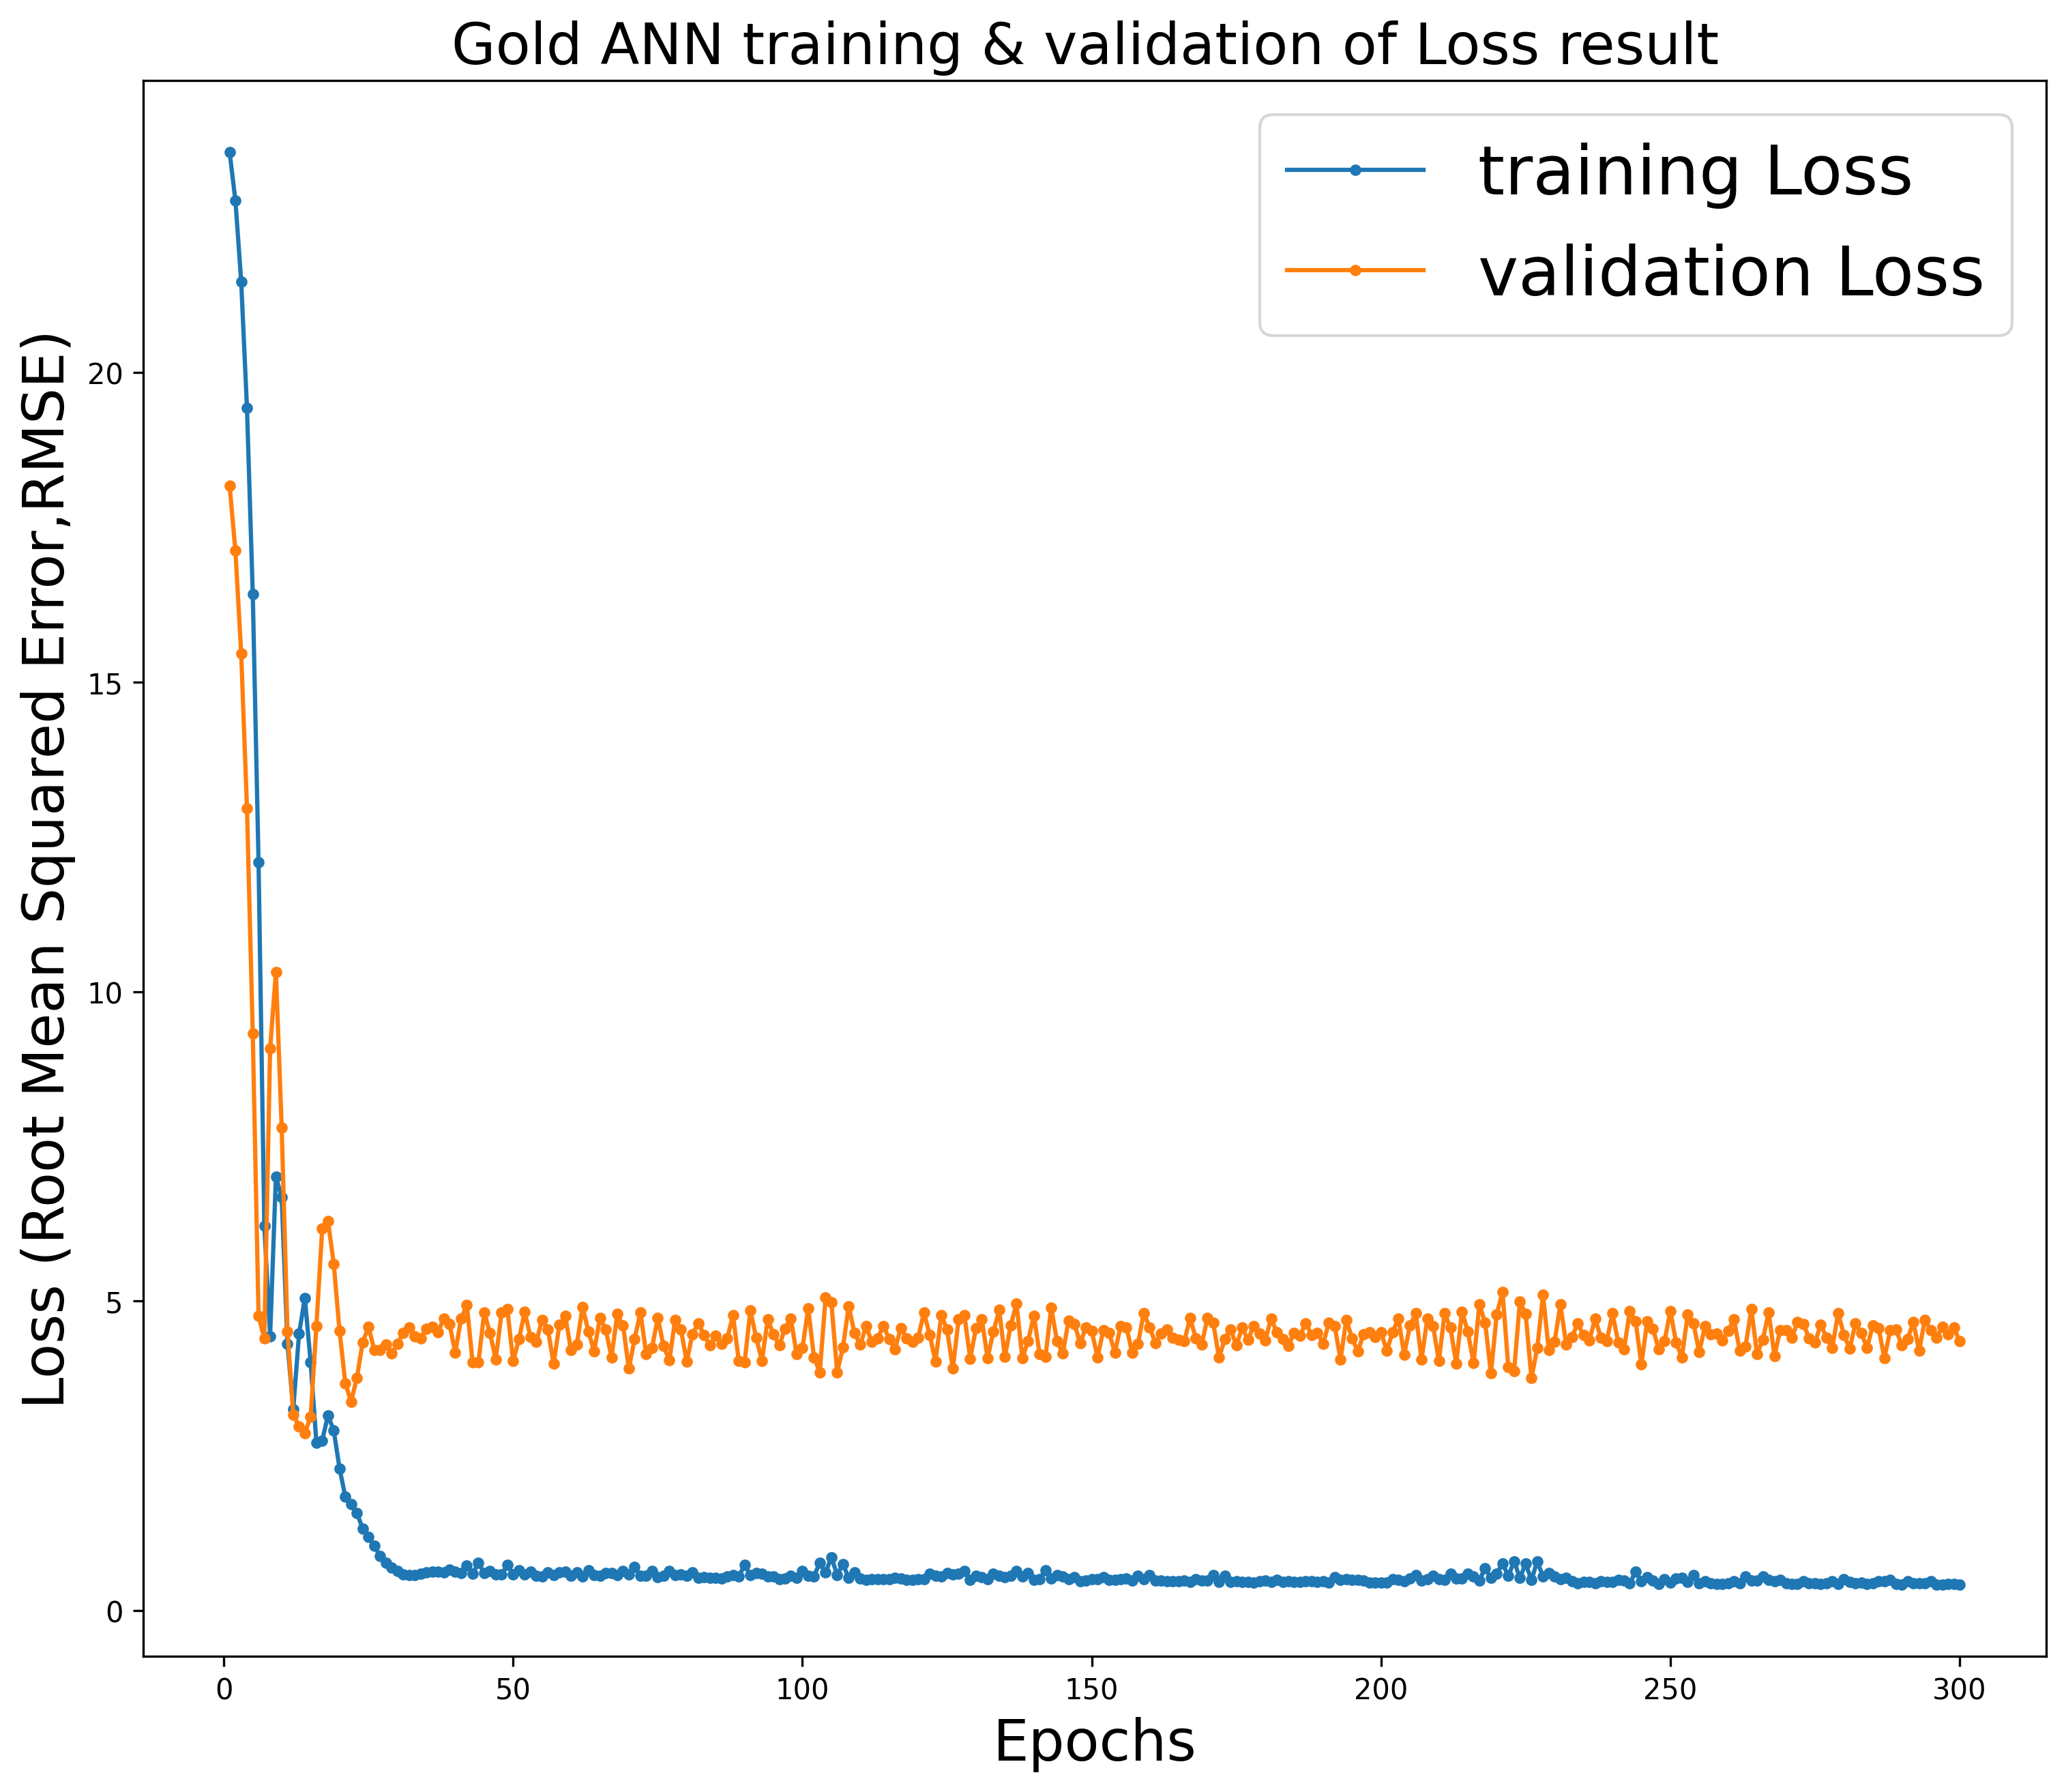

In [261]:
# 7.2 Plot the history of training and validation
training_loss_values=modeling_result['loss']
val_loss_values=modeling_result['val_loss']
epochs=range(1,len(training_loss_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss (Root Mean Squared Error,RMSE)',fontsize=20)
plt.title('Gold ANN training & validation of Loss result ',fontsize=20)

plt.plot(epochs, training_loss_values,marker='.',label='training Loss')
plt.plot(epochs, val_loss_values,marker='.',label='validation Loss')
plt.legend(loc=1,fontsize=24)
plt.show()

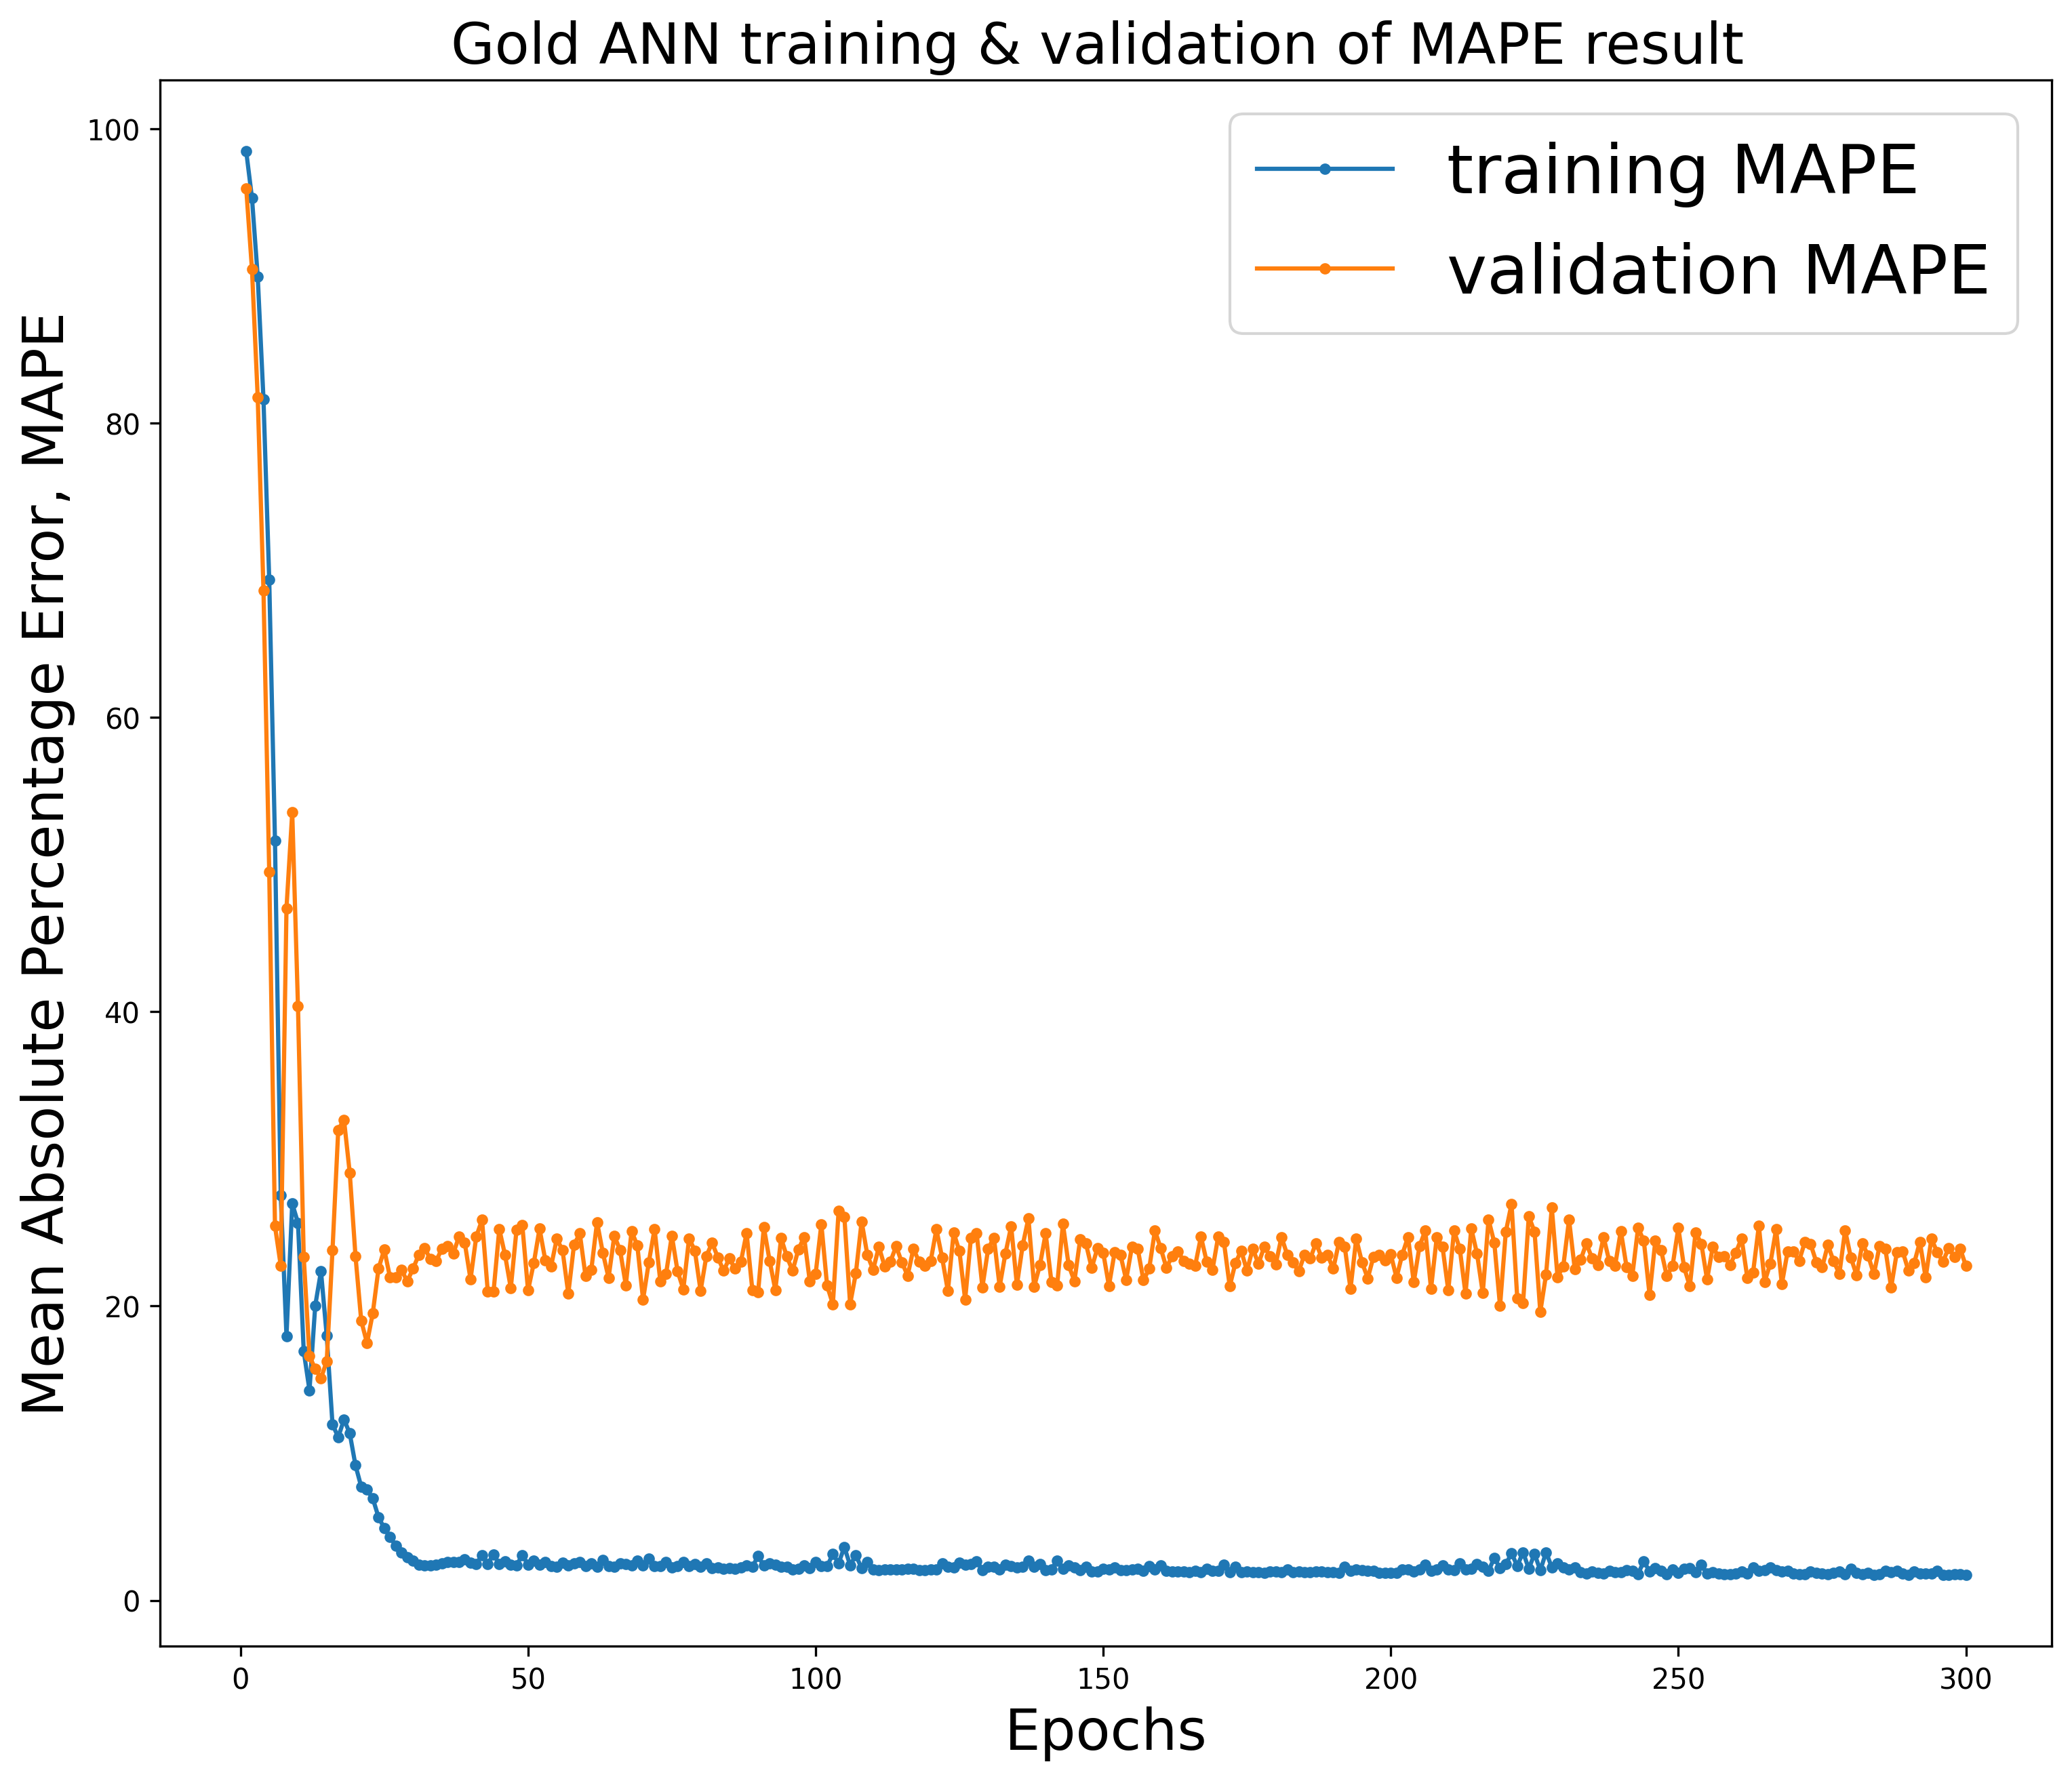

In [262]:
# 7.2 Plot the history of training and validation
training_acc_values=modeling_result['mean_absolute_percentage_error']
val_acc_values=modeling_result['val_mean_absolute_percentage_error']
epochs=range(1,len(training_acc_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Mean Absolute Percentage Error, MAPE',fontsize=20)
plt.title('Gold ANN training & validation of MAPE result ',fontsize=20)

plt.plot(epochs, training_acc_values,marker='.',label='training MAPE')
plt.plot(epochs, val_acc_values,marker='.',label='validation MAPE')
plt.legend(loc=1,fontsize=24)
plt.show()

# Fit the final model with all of the training data

In [263]:
# X all train data
x_forecast_train=Forecast_train_data.drop(['Date','Y'],axis=1).copy()
# Y all train data
y_forecast_train=Forecast_train_data['Y'].copy()

In [264]:
# Create the model
clear.clear_session()
Fmodel=Sequential()

# Add input layer & first hidden layer
Fmodel.add(Dense(units=6, input_dim=3, activation='relu'))

# Add second hidden layer
Fmodel.add(Dense(units=12, activation='linear'))

# Add third hidden layer
Fmodel.add(Dense(units=24, activation='relu'))

# Add output layer
Fmodel.add(Dense(units=1, activation='linear'))

# Compile the defined Net
#opt=SGD(learning_rate=0.001,momentum=0.5)
opt=Adam(learning_rate=0.007,beta_1=0.97)
Fmodel.compile(loss='my_RMSE', optimizer=opt, metrics=['mean_absolute_percentage_error'])

# Finally check the model 
Fmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 24        
                                                                 
 dense_1 (Dense)             (None, 12)                84        
                                                                 
 dense_2 (Dense)             (None, 24)                312       
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                                 
Total params: 445
Trainable params: 445
Non-trainable params: 0
_________________________________________________________________


In [265]:
# Store in the history for more useful information
history=Fmodel.fit(x_forecast_train, y_forecast_train, epochs=300, batch_size=64,verbose=1)

Epoch 1/300
11/11 [==============================] - 1s 3ms/step - loss: 9.0102 - mean_absolute_percentage_error: 42.1703
Epoch 2/300
11/11 [==============================] - 0s 3ms/step - loss: 1.5711 - mean_absolute_percentage_error: 7.3235
Epoch 3/300
11/11 [==============================] - 0s 3ms/step - loss: 1.3003 - mean_absolute_percentage_error: 6.1620
Epoch 4/300
11/11 [==============================] - 0s 3ms/step - loss: 1.0506 - mean_absolute_percentage_error: 4.9199
Epoch 5/300
11/11 [==============================] - 0s 3ms/step - loss: 0.7213 - mean_absolute_percentage_error: 3.4012
Epoch 6/300
11/11 [==============================] - 0s 3ms/step - loss: 0.6945 - mean_absolute_percentage_error: 3.2593
Epoch 7/300
11/11 [==============================] - 0s 3ms/step - loss: 0.6040 - mean_absolute_percentage_error: 2.8437
Epoch 8/300
11/11 [==============================] - 0s 3ms/step - loss: 0.5554 - mean_absolute_percentage_error: 2.5933
Epoch 9/300
11/11 [============

In [266]:
# 7.3 Save the trained model
#Fmodel.save('D:/data_analysis/PyExport/Rainfall_forecast_ANN_trained_model.h5')
# Colab
Fmodel.save('/content/drive/MyDrive/ann_timeseries/Gold_0007097.h5')
print('Model has been saved...')

Model has been saved...


In [267]:
# 7.4 Restore the saved model for testing
#ANN_model=keras.models.load_model('D:/data_analysis/PyExport/Rainfall_forecast_ANN_trained_model.h5')
# Colab
ANN_model=keras.models.load_model('/content/drive/MyDrive/ann_timeseries/Gold_0007097.h5')
print('Model successfully loaded...')

Model successfully loaded...


# 8. Testing

In [268]:
# X test
x_forecast_test=Forecast_test_data.drop(['Date','Y'],axis=1).copy()
# Y test
y_forecast_test=Forecast_test_data['Y'].copy()

In [269]:
# 8.1 Make prediction 
prediction=np.round((ANN_model.predict_on_batch(x_forecast_test)),2)
pred_values=[]
for i in range(0,len(prediction)):
    value=prediction[i][0]
    pred_values.append(value)

In [270]:
Results=pd.DataFrame({'Date':Forecast_test_data['Date'],'Y_true':Forecast_test_data['Y'],'Predict':pred_values})
Results['abs Error']=np.abs(Results['Y_true']-Results['Predict'])
Results

,Date,Y_true,Predict,abs Error
646,2022-12-21,17.500000,16.690001,0.809999
647,2022-12-22,17.299999,17.070000,0.229999
648,2022-12-23,17.389999,17.030001,0.359998
649,2022-12-27,17.770000,17.020000,0.750000
650,2022-12-28,17.209999,17.280001,0.070002
...,...,...,...,...
749,2023-05-22,17.790001,17.490000,0.300001
750,2023-05-23,17.750000,17.459999,0.290001
751,2023-05-24,17.480000,17.410000,0.070000
752,2023-05-25,17.090000,17.230000,0.140000


In [271]:
# 8.2 Calculating the mertics
MAE=mean_absolute_error(y_forecast_test,pred_values)
MSE=mean_squared_error(y_forecast_test,pred_values,squared=True)
RMSE=mean_squared_error(y_forecast_test,pred_values,squared=False)
MAPE=mean_absolute_percentage_error(y_forecast_test,pred_values)
SMAPE=SMAPE_calulate(y_forecast_test,pred_values)
RAE=RAE_calculate(y_forecast_test,pred_values)
MRAE=MRAE_calculate(y_forecast_test,pred_values)
MdRAE=MdRAE_calculate(y_forecast_test,pred_values)
RSE=RSE_calculate(y_forecast_test,pred_values,Root=False)
RRSE=RSE_calculate(y_forecast_test,pred_values,Root=True)

print('MAE:',round(MAE,3))
print('MSE:',round(MSE,3))
print('RMSE:',round(RMSE,3))
print('MAPE:',round(MAPE*100,3),'%')
print('SMAPE:',round(SMAPE,3),'%')
print('RAE:',round(RAE,3))
print('MRAE:',MRAE)
print('MdRAE:',round(MdRAE[0],3),'bench:',round(MdRAE[1],3))
print('RSE:',round(RSE,3))
print('RRSE:',round(RRSE,3))

MAE: 0.442
MSE: 0.293
RMSE: 0.542
MAPE: 2.39 %
SMAPE: 2.429 %
RAE: 0.428
MRAE: 0.003964878912332884
MdRAE: 0.453 bench: 18.332
RSE: 0.197
RRSE: 0.443


#  Plot for comparing true value & predicted value 

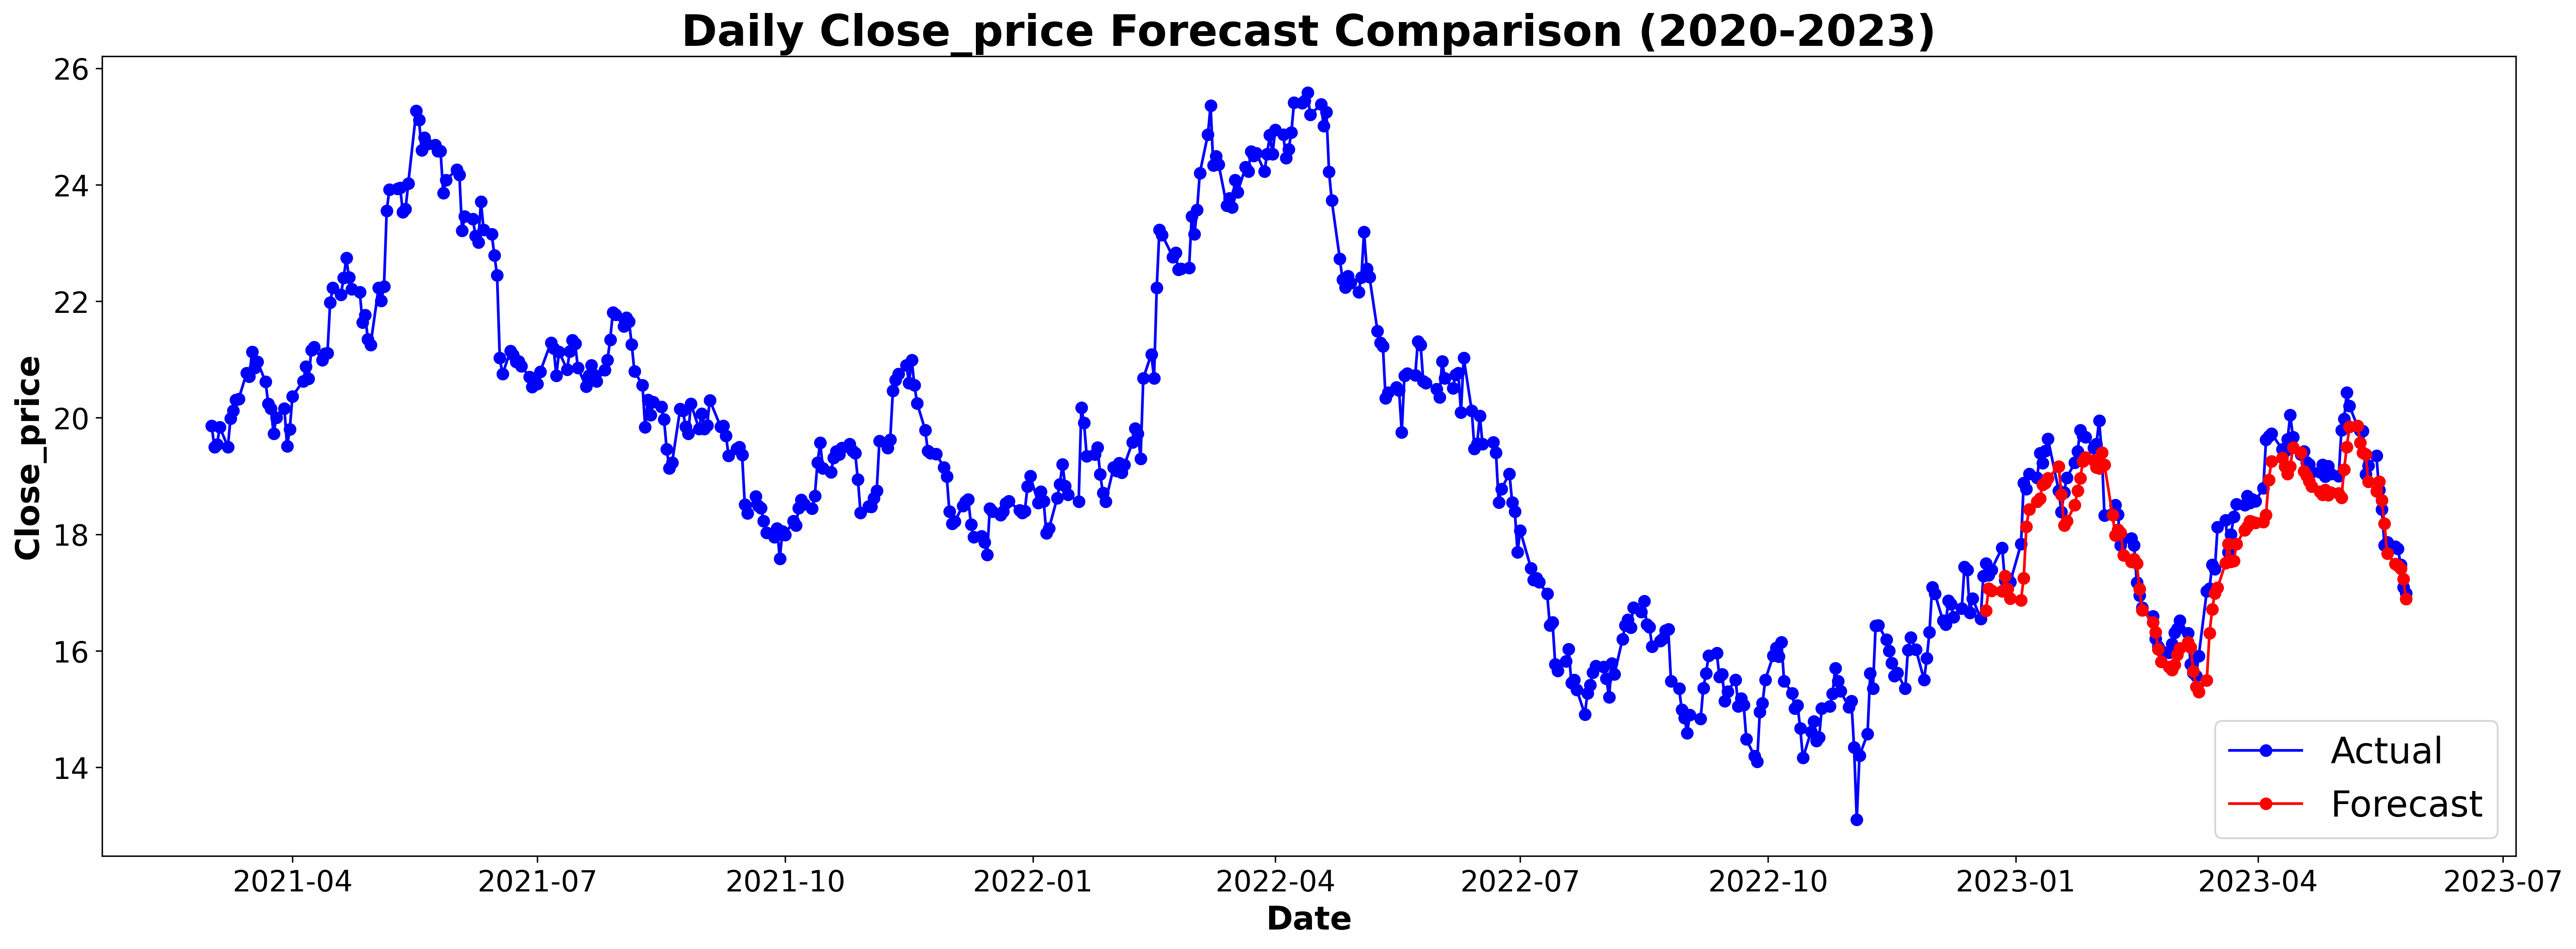

In [272]:
# Plot Y and its corresponding date
# Figure setting
plt.figure(figsize=(24,8),dpi=300)
plt.title('Daily Close_price Forecast Comparison (2020-2023)',weight='bold',fontsize=24)
plt.xlabel('Date',fontsize=18,weight='bold')
plt.ylabel('Close_price',fontsize=18,weight='bold')

# Comparison of actual value and predicted value according to Date
plt.plot(clean_df.iloc[189:,0],clean_df.iloc[189:,1],marker='o',color='blue',label='Actual')
plt.plot(Results['Date'],Results['Predict'],marker='o',color='red',label='Forecast')

# Set the axis
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Set legends
plt.legend(loc=4,fontsize=20)

plt.show()

# Actual by predicted plot

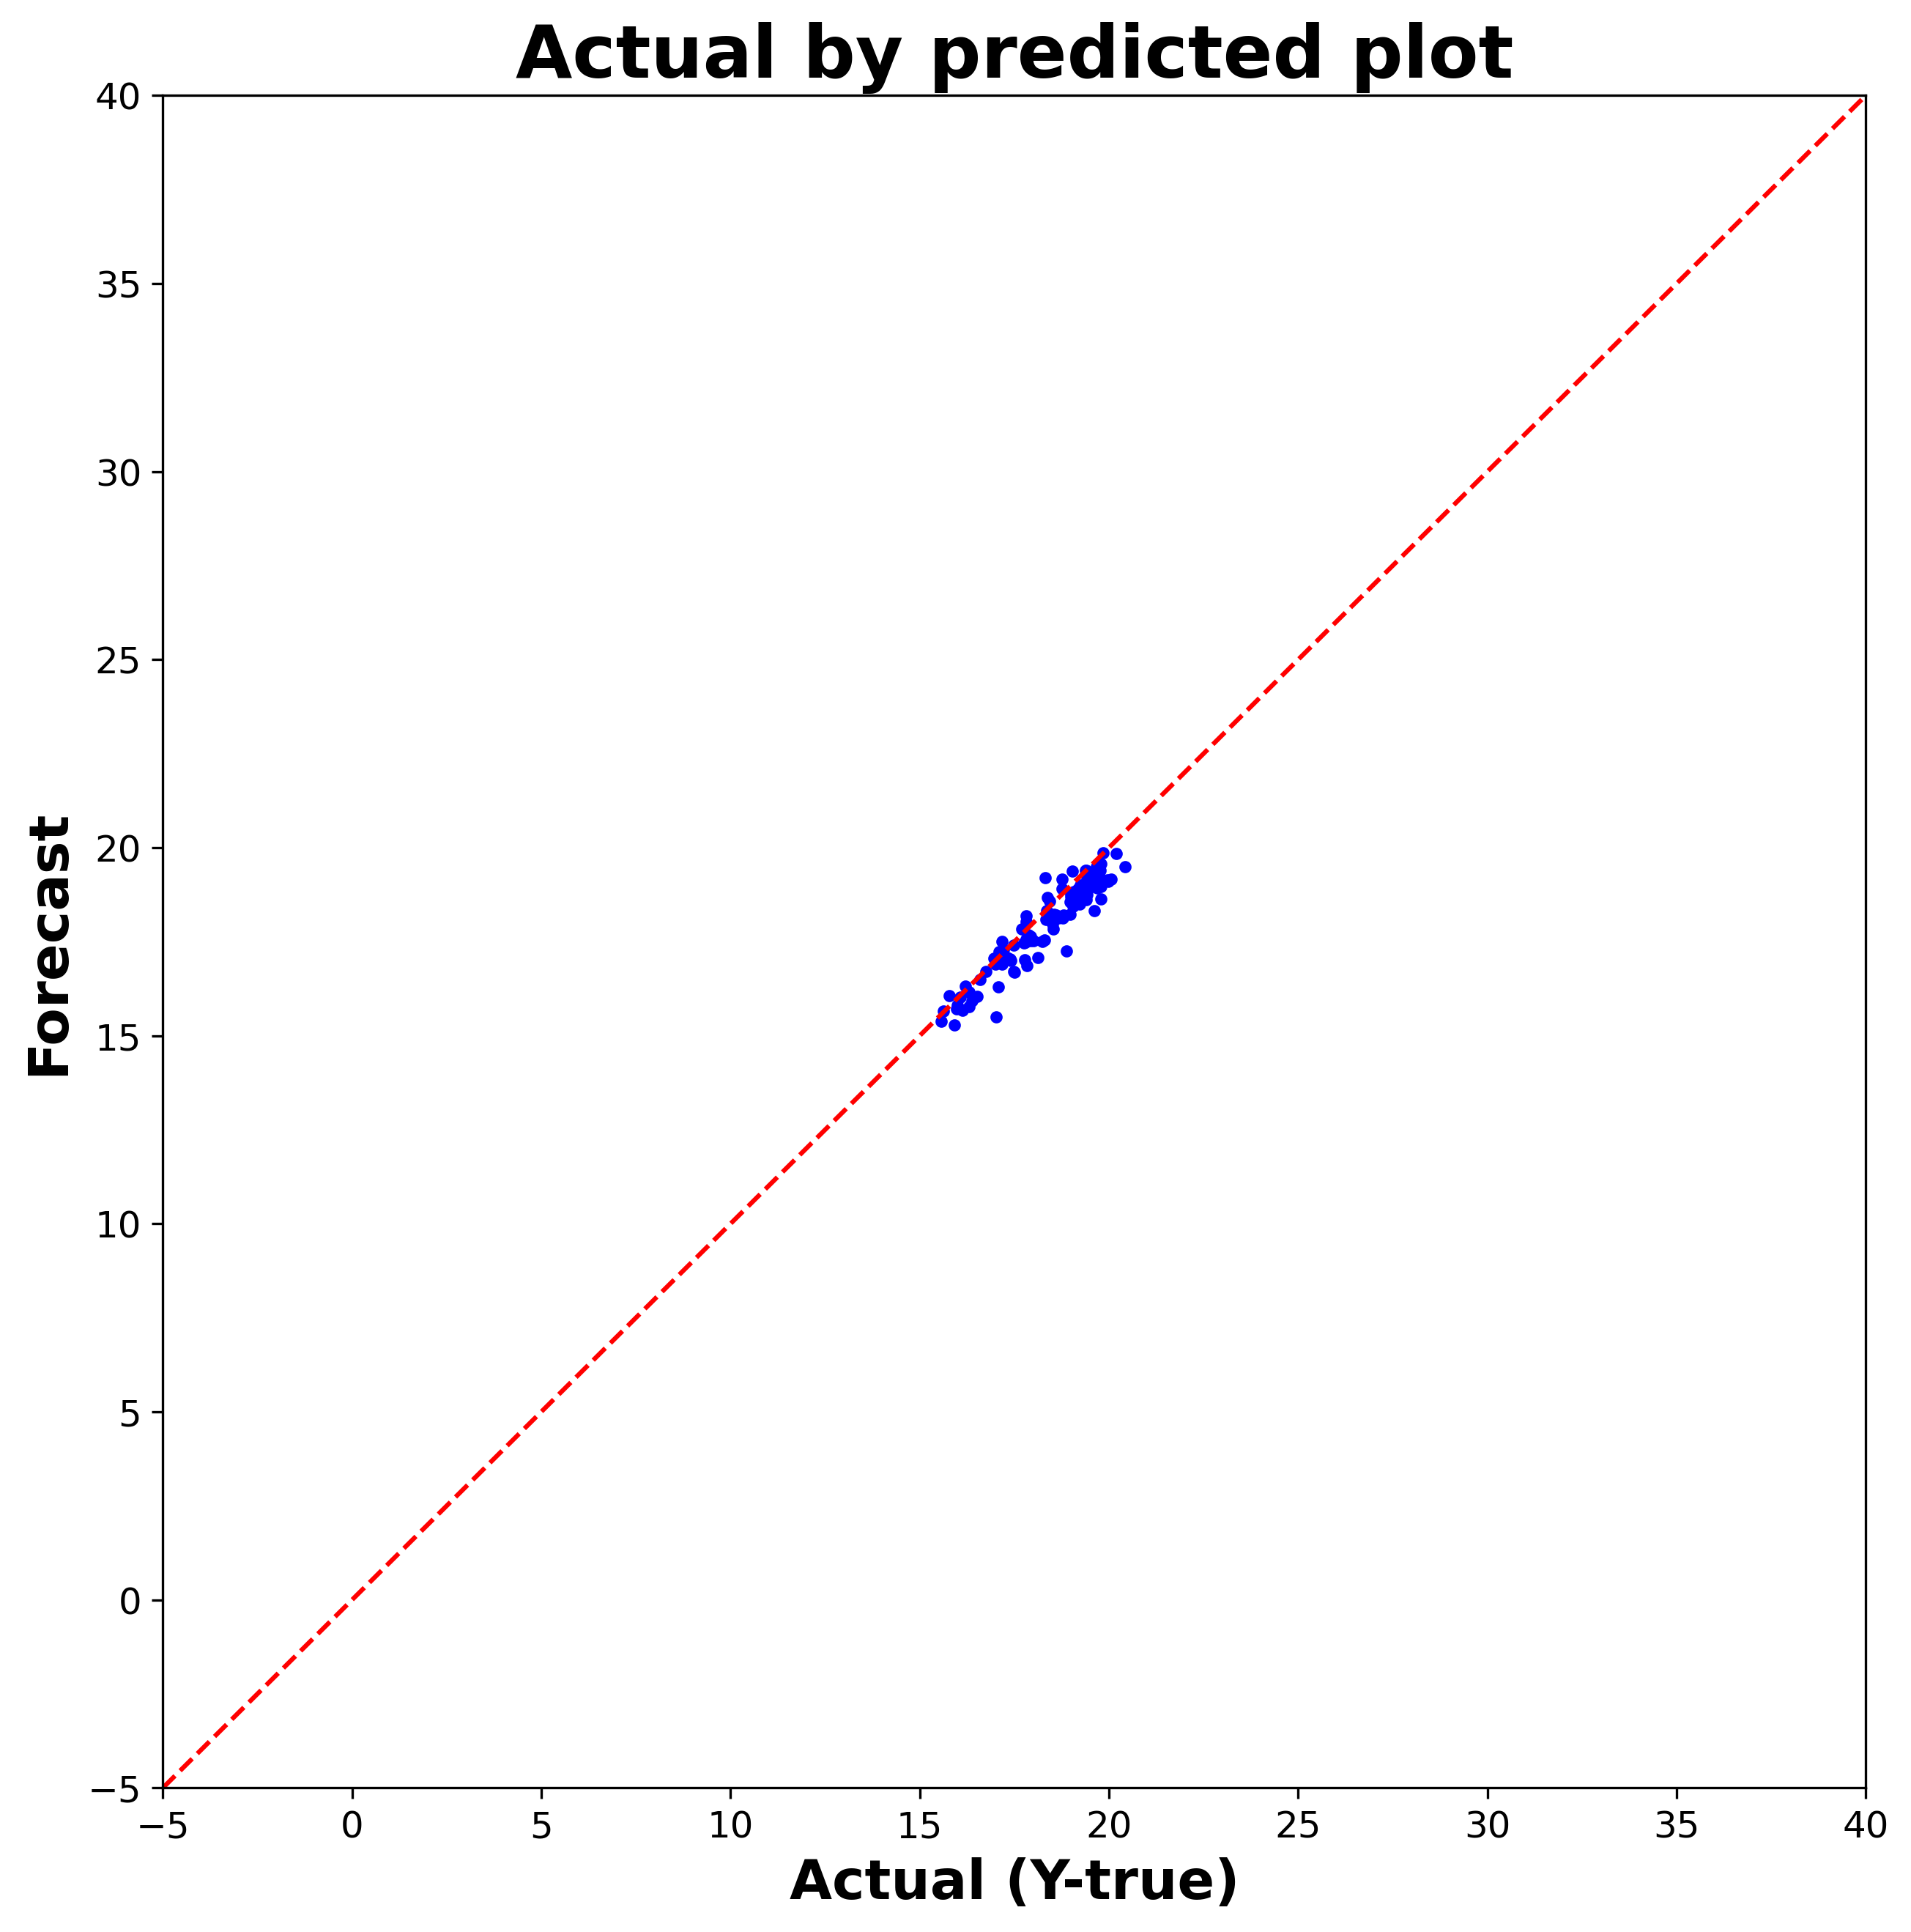

In [273]:
# Lock the scale of axis by Y_true
max_value=35+5
min_value=0-5

# Figure setting
plt.figure(figsize=(10,10),dpi=300)
plt.title('Actual by predicted plot',weight='bold',fontsize=24)
plt.xlabel('Actual (Y-true)',fontsize=18,weight='bold')
plt.ylabel('Forecast',fontsize=18,weight='bold')

# Perfect model reference line
plt.plot([min_value,max_value], [min_value,max_value], linestyle='--',color='red')

# Actual by predicted plot
plt.scatter(Results.iloc[:,1],Results.iloc[:,2],marker='.',color='blue')

# Set the axis
plt.ylim(0-5,max_value)
plt.xlim(0-5,max_value)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()